# 03wk-1: 파이토치식 코딩패턴 (2), 로지스틱-ToyData1, 로지스틱-ToyData2

## 1. imports

In [2]:
import torch
import matplotlib.pyplot as plt 

In [3]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

## 2. 파이토치식 코딩패턴 (2)

*데이터*

In [11]:
torch.manual_seed(43052)
x,_ = torch.randn(100).sort()
eps = torch.randn(100)*0.5
X = torch.stack([torch.ones(100),x],axis=1)
W = torch.tensor([[2.5],[4.0]])
y = X@W + eps.reshape(100,1)
x = X[:,[1]]

`-` 모델링 : 에러가 포함된 자료에서 error-free한 structure를 찾는 것

> error-free한 structure를 찾으려고 노력해야지, error를 따라가려고 노력하면 안됨 -> 오버피팅

`-` 오차 : error-free한 structure(모델)과 실제 관측 데이터간의 차이를 설명해주는 역할

> $y \approx XW, ~ y = XW + \epsilon$

### A. bias의 사용

`net`에서 `bias`를 사용 : `net` object에는 weight와 bias가 동시에 들어가 있음.

$$y = XW + \text{bias} + \epsilon$$

> 설명변수 행렬에서 절편을 분리한 구조

In [ ]:
## bias = False인 경우.
net = torch.nn.Linear(
    in_features = 2,
    out_features = 1,
    bias = False
)
net.weight.data = torch.tensor([[-5.0, 10.0]]) ## 이걸 설정하지 않아도 알아서 잘 해주긴 하네...

loss_fn = torch.nn.MSELoss()

optimizr = torch.optim.SGD(net.parameters(), lr = 0.1)

for epoc in range(30) :
    # 1 : yhat
    yhat = net(X)
    # 2 : loss
    loss = loss_fn(yhat, y)
    # 3 : 미분
    loss.backward()
    # 4 : update
    optimizr.step()
    optimizr.zero_grad()

In [17]:
# step1을 위한 사전준비
net = torch.nn.Linear(
    in_features=1,
    out_features=1,
    bias=True
) # net(x) = x@net.weight.T + net.bias 
net.bias.data = torch.tensor([-5.0])
net.weight.data = torch.tensor([[10.0]])
# step2를 위한 사전준비
loss_fn = torch.nn.MSELoss()
# step4를 위한 사전준비 
optimizr = torch.optim.SGD(net.parameters(),lr=0.1)
for epoc in range(30):
    # step1: yhat 
    yhat = net(x)
    # step2: loss
    loss = loss_fn(yhat,y)
    # step3: 미분
    loss.backward()
    # step4: update
    optimizr.step()
    optimizr.zero_grad()

In [19]:
net.bias.data, net.weight.data

(tensor([2.4290]), tensor([[4.0144]]))

### B. 잘못된(?) 코드

In [20]:
?torch.nn.Linear

Init signature:
torch.nn.Linear(
    in_features: int,
    out_features: int,
    bias: bool = True,
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies an affine linear transformation to the incoming data: :math:`y = xA^T + b`.

This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

Args:
    in_features: size of each input sample
    out_features: size of each output sample
    bias: If set to ``False``, the layer will not learn an additive bias.
        Default: ``True``

Shape:
    - Input: :math:`(*, H_{in})` where :math:`*` means any number of
      dimensions including none and :math:`H_{in} = \text{in\_features}`.
    - Output: :math:`(*, H_{out})` where all but the last dimension
      are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

Attributes:
    weight: the learnable weights of the module of shape
 

`bias`의 디폴트는 True

In [21]:
# step1을 위한 사전준비
net = torch.nn.Linear(
    in_features=2,
    out_features=1,
)
net.weight.data = torch.tensor([[-5.0,  10.0]])
# step2를 위한 사전준비
loss_fn = torch.nn.MSELoss()
# step4를 위한 사전준비 
optimizr = torch.optim.SGD(net.parameters(),lr=0.1)
for epoc in range(30):
    # step1: yhat 
    yhat = net(X)
    # step2: loss
    loss = loss_fn(yhat,y)
    # step3: 미분
    loss.backward()
    # step4: update
    optimizr.step()
    optimizr.zero_grad()

In [22]:
net.weight

Parameter containing:
tensor([[-1.3003,  4.0080]], requires_grad=True)

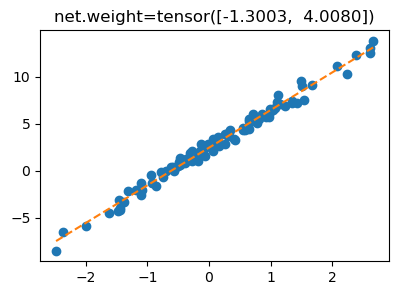

In [23]:
plt.plot(x,y,'o')
plt.plot(x,yhat.data,'--')
plt.title(f'net.weight={net.weight.data.reshape(-1)}');

`-` 나쁘지 않은 이유?

In [25]:
net.weight, net.bias

(Parameter containing:
 tensor([[-1.3003,  4.0080]], requires_grad=True),
 Parameter containing:
 tensor([3.7452], requires_grad=True))

In [28]:
X[[0], :]

tensor([[ 1.0000, -2.4821]])

In [29]:
-1.3003*1 + 4.0080*(-2.4821) + 3.7452

-7.503356799999999

In [32]:
yhat[0]

tensor([-7.5062], grad_fn=<SelectBackward0>)

> 절편이 두 개로 나뉘었을 뿐... -> 어떤 관점에서는 그냥 조금 비효율적일 뿐, 상관 없다고 생각하기도...

## 3. 로지스틱 - ToyData 1

### A. $\hat{\bf y} = ??$

> 어떤 y가 상태를 의미할 때가 있음.

`-` $\bf X$를 가지고 $\bf y$를 맞추는 문제

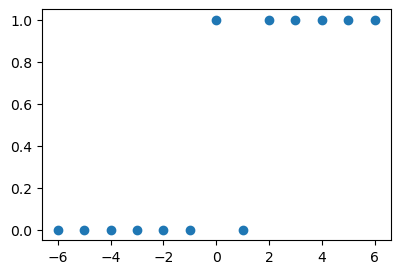

In [34]:
x = torch.tensor([-6,-5,-4,-3,-2,-1, 0, 1, 2, 3, 4, 5, 6.0]).reshape(-1,1)
y = torch.tensor([ 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1]).reshape(-1,1)
plt.plot(x,y,'o');

> 회귀분석 식으로 언더라잉을 만들고, 오차를 설명하면 안됨. 애초에 실제 상황에선 0과 1밖에 없으니까... 정규분포는 이상함
>
> 각 포인트에서 베르누이 시행을 하는 상황이라면? 그 성공 확률을 언더라잉으로 만들면? 베르누이 시행에 의한 랜덤성을 오차라고 설명하면 됨.

오차항까지 함께 설명을 할 수 있어야 모델링에서의 의미가 있음.

* $\hat y \in [0, 1]$. 추세선을 찾고 싶은 거지, 데이터를 그대로 따라가는 것이 아님.

`-` 아래와 같이 모형화하면?

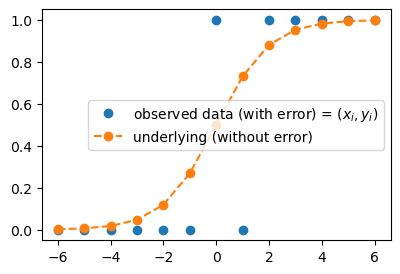

In [ ]:
plt.plot(x,y,'o', label=r"observed data (with error) = $(x_i,y_i)$")
plt.plot(x,torch.exp(x)/(1+torch.exp(x)),'o--', label = "underlying (without error)") ## 시그모이드 함수
plt.legend()
plt.show()

### B. $\hat{\bf y} = \frac{\exp(\text{linr}({\bf X}))}{1+\exp(\text{linr}({\bf X}))}$

`-` 걱정: 산점도가 꼭 아래와 같은 방식이 아니라면 어쩌지?

-   $x$가 증가할수록 $y$가 0이 된다면?
-   0근처에서 변화가 일어나지 않고 2근처에서 변화가 일어난다면?
-   변화가 좀 더 급하게 (혹은 완만하게 일어난다면?)

`-` 걱정해결

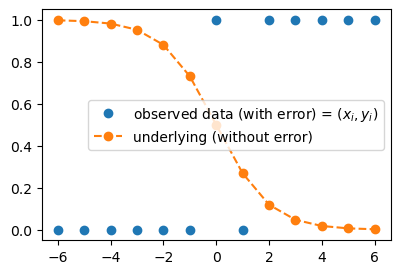

In [ ]:
## 계수를 음수로
plt.plot(x,y,'o', label=r"observed data (with error) = $(x_i,y_i)$")
plt.plot(x,torch.exp(-x)/(1+torch.exp(-x)),'o--', label = "underlying (without error)") ## 시그모이드 함수
plt.legend()
plt.show()

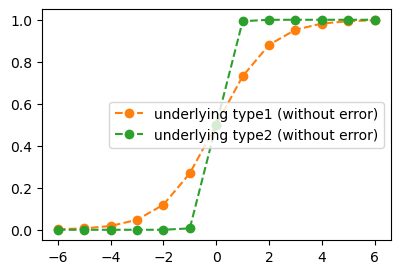

In [ ]:
## 계수의 절대값을 더 크게
#plt.plot(x,y,'o', label=r"observed data (with error) = $(x_i,y_i)$")
plt.plot(x,torch.exp(x)/(1+torch.exp(x)),'o--', label = "underlying type1 (without error)", color="C1")
plt.plot(x,torch.exp(5*x)/(1+torch.exp(5*x)),'o--', label = "underlying type2 (without error)", color="C2")
plt.legend()

$$\log\frac{P_x}{1-P_x} = ax + b \Rightarrow \frac{1}{1-P_x} - 1 = e^{ax + b} \Rightarrow 1-P_x = \frac{1}{e^{ax + b} + 1} \Rightarrow P_x = \frac{e^{ax + b}}{e^{ax+b}+1}$$

> 아무튼 X를 적당한 선형 변환을 하여 다양한 곡선들을 만들 수 있다.


> **Note**
>
> **회귀 vs 로지스틱**
>
> -   ${\bf X} \to {\bf y}$ 에 대한 패턴이
>     $\text{linr}({\bf X}) \approx {\bf y}$ 이라면 회귀!
> -   ${\bf X} \to {\bf y}$ 에 대한 패턴이
>     $\frac{\exp(\text{linr}({\bf X}))}{1+\exp(\text{linr}({\bf X}))} \approx {\bf y}$
>     이라면 로지스틱!

파라미터 기본값을 설정해주지 않아도 잘 되던데, 뭘 디폴트로 하는 걸까.

## 5. 로지스틱 - ToyData2

### A. 로지스틱 모형

`-` $x$가 커질수록 $y=1$이 잘나오는 모형은 아래와 같이 설계할 수 있음
\<— 외우세요!!!

-   $y_i \sim {\cal B}(\pi_i),\quad$ where
    $\pi_i = \frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)} = \frac{1}{1+\exp(-w_0-w_1x_i)}$

-   $\hat{y}_i= \frac{\exp(\hat{w}_0+\hat{w}_1x_i)}{1+\exp(\hat{w}_0+\hat{w}_1x_i)}=\frac{1}{1+\exp(-\hat{w}_0-\hat{w}_1x_i)}$

`-` 회귀모형과 로지스틱 모형의 비교

-   회귀모형: $y_i \sim {\cal N}(w_0+w_1x_i, \sigma^2)$[1]
-   로지스틱:
    $y_i \sim {\cal B}\big(\frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)}\big)$

`-` 우리가 예측하고 싶은것

-   회귀모형: 정규분포의 평균을 예측하고 싶음. 즉 $w_0+w_1x_i$를
    예측하고 싶음. 예측값으로는 $\hat{w}_0 + \hat{w}_1x_i$를 사용!
-   로지스틱: 베르누이의 평균($p$)을 예측하고 싶음. 즉
    $\frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)}$를 예측하고 싶음.
    예측값으로는
    $\frac{\exp(\hat{w}_0+\hat{w}_1x_i)}{1+\exp(\hat{w}_0+\hat{w}_1x_i)}$를
    사용!

> 결론적으로 파라미터만 잘 구하면 됨

### B. 데이터

[1] 원래는 이렇게 썼었지..
$y_i = w_0 + w_1x_i + \epsilon_i \quad \epsilon_i \sim {\cal N}(0,\sigma^2)$